# Machine Learning Project - Cryptocurrencies price variations prediction

In [3]:
#import usefull packages
import pandas as pd
import numpy as np
from numpy import absolute
import matplotlib.pyplot as plt
import glob
import ta
import collections
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



## See below for detailed steps of the following function (step by step, plots, comments...)

In [4]:
def features_selection(crypto_csv_file):
    
    
    # load data 
    Crypto = pd.read_csv(crypto_csv_file) 
    
    #get the name of the crypto 
    crypto_name = Crypto["Name"][0]
    #print(crypto_name)
    
    # Clean nan values
    Crypto = ta.utils.dropna(Crypto)

    # Add all technical analysis features filling nans values
    Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)
    
    # List of our indicators 
    indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']
    
    # compute the returns 
    Crypto["Returns"] = Crypto["Close"].pct_change()

    # keep only the relevant columns, ie. the ta indicators and the returns. 
    Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN
    
    # split into train and test sets
    Crypto_train, Crypto_test = train_test_split(Crypto,train_size = 0.80,random_state=None, shuffle=False)
    
    # standardize
    sc = StandardScaler()
    Z_Crypto_train = sc.fit_transform(Crypto_train)
    
    # Lasso regression (alpha = 1.0)
    from sklearn.linear_model import Lasso
    regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
    
    # Rename for clarity 
    # We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date
    X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])
    
    # fit
    regLasso1.fit(X,y)
    
    # obtain coeffficients of the LASSO regression for multiple alphas
    from sklearn.linear_model import lasso_path
    alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

    # number of non-nul coefficients for each alpha
    nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
    alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})
    
    # get the alpha for which we get 8 selected features (and its index)
    # If no such alpha exists, choose an alpha for which we get 7 selected features, etc...
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    while np.isnan(higher_alpha_to_get_8_features) == True :
        alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
        higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
        
    # get the 8 selected features coressponding 
    coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
    index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
    coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
    selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
    
    return crypto_name, selected_features
    
  

#### Run the Features Selection

In [5]:
# get a list of all csv files 
path = "/Users/nicolaspaganel/Desktop/GitHub/ML_Finance/Crypto df"
all_cryptos_csv_files = glob.glob(path + "/*.csv" )

# initialize dictionary with final selected features for each crypto
selected_features_per_crypto = {}

# get all selected features for each crpytocurrency 
for crypto_csv_file in all_cryptos_csv_files:
    
    crypto_name, features = features_selection(crypto_csv_file)
    
    # add selected features to the dictionray
    selected_features_per_crypto[crypto_name] = features
    

#### Retults of the Features Selection

In [6]:
# Results as table
pd.set_option("display.max_columns", 100)
Table_Selected_Features = pd.DataFrame({ key:pd.Series(value) for key, value in selected_features_per_crypto.items() }).fillna("NaN")
Table_Selected_Features.index.name = 'Features'
Table_Selected_Features.index += 1
Table_Selected_Features




""
Features


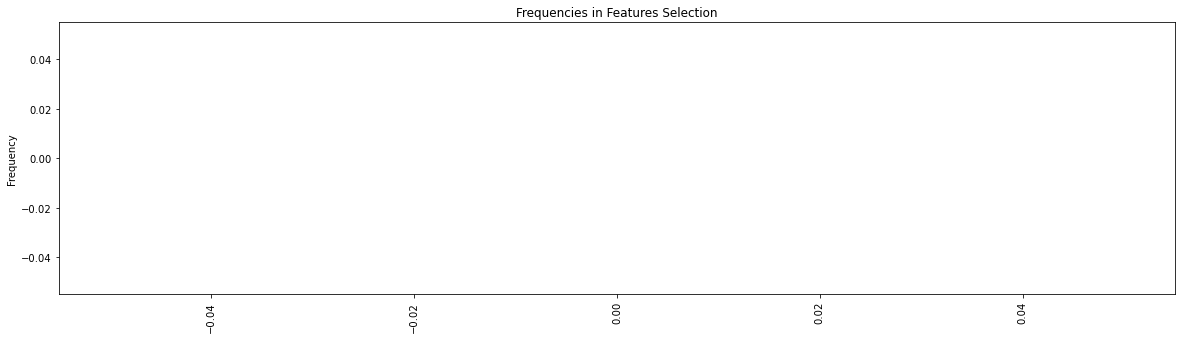

In [7]:
# Plot the dsitribution of apparition of the different features 
liste = Table_Selected_Features.values.tolist()
full_liste = []
for i in range(len(liste)):
    for j in range(len(liste[i])):
        full_liste.append(liste[i][j])
        
occurrences = collections.Counter(full_liste)
y = [count for tag, count in occurrences.most_common()]
x = [tag for tag, count in occurrences.most_common()]

f, ax = plt.subplots(figsize=(20,5))
plt.bar(x, y)
plt.title("Frequencies in Features Selection")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


## DETAILED STEPS of the Features Selection function

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


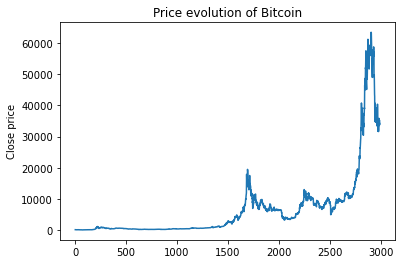

In [8]:
# load data 

Crypto = pd.read_csv("/Users/diego/OneDrive/Bureau/GitHub/ML_Finance/Crypto df/coin_Bitcoin.csv") 

# let's have a look at the data
plt.plot(Crypto["Close"])
plt.ylabel("Close price")
crypto_name = Crypto["Name"][0]
plt.title("Price evolution of " + crypto_name)
Crypto.head()

In [9]:
# Clean nan values

Crypto = ta.utils.dropna(Crypto)

# Add all technical analysis features filling nans values

Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)

#print(Cardano.columns)

C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [10]:
# List of our indicators 

indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [11]:
# compute the returns 

Crypto["Returns"] = Crypto["Close"].pct_change()

# keep only the relevant columns, ie. the ta indicators and the returns. 

Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN

Crypto

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Returns
243,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,0.000000,-2482.908219,-2482.908219,-4.245126e+07,990.150611,735.788338,0.000000,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.000000,0.000000,0.000000,0.005063,0.010919,-0.005856,-0.001924,1.943639,-66.666667,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,731.817595,0.000000,-2.500653,-0.500131,-2.000522,-0.984939,-0.989821,-0.984939,-0.009849
244,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,37.199037,956.192156,-763.358031,1.296324e+05,1013.576912,735.835681,0.000000,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.000000,0.000000,0.000000,0.011550,0.015774,-0.004224,-0.000474,2.831246,13.251992,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,0.000000,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,738.216009,0.000000,-7.088933,-1.817891,-5.271042,2.365933,2.338379,1.357691,0.023659
245,6.464174e+06,5.407590e+07,0.054281,-1.000401e+08,55.625599,2787.135170,420.139703,7.577494e+05,1013.576912,739.050431,0.000000,741.020004,762.325663,719.714345,5.750360,0.854601,0.0,0.0,739.790827,781.328334,698.253321,11.229527,0.696680,0.0,0.0,705.349976,777.510010,741.429993,9.737933,0.703714,0.000000,1.956971,0.373502,1.583470,741.020004,741.020004,738.811690,736.854718,0.000000,0.000000,0.000000,0.019325,0.016967,0.002359,0.006118,3.661183,115.325833,6539.252222,-898.215344,-898.921247,0.705903,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,16.0,8.0,8.0,-1.000000,776.248610,0.0,0.0,0.000000,81.260429,0.000000,0.000000,0.000000,-87.732937,41.516721,70.371404,52.180354,-29.628596,0.000000,746.502271,0.000000,-10.620253,-3.578364,-7.041890,1.487151,1.476201,2.865033,0.014872
246,1.510844e+07,3.317860e+07,0.107929,-9.207753e+07,42.962004,-433.779509,206.659900,2.493640e+05,1013.576912,740.822352,0.000000,743.618005,765.323734,721.912277,5.837871,0.739384,0.0,0.0,742.016663,779.728674,704.304651,10.164734,0.659012,0.0,0.0,705.349976,777.510010,741.429993,9.7

In [12]:
## look at the correlations between the features and the returns

#pd.DataFrame(np.corrcoef(Crypto, rowvar=False))

# if a coefficient is > 0.9 , drop it

#######                     #######
####### CODE GENERALIZATION #######
#######                     #######


#(so far, we did it manually, not good)



In [13]:
# split into train and test sets

Crypto_train, Crypto_test = train_test_split(Crypto,train_size = 0.80,random_state=None, shuffle=False)

In [14]:
# standardize

sc = StandardScaler()
Z_Crypto_train = sc.fit_transform(Crypto_train)

In [15]:
# Lasso regression (alpha = 1.0)

from sklearn.linear_model import Lasso
regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
#print(regLasso1)

In [16]:
# Rename for clarity 
# We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date

X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])

In [17]:
# fit

regLasso1.fit(X,y)

Lasso(fit_intercept=False)

In [18]:
# obtain coeffficients of the LASSO regression for multiple alphas

from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.840989812838643, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4684640111483986, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8972506865666219, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.823396033147901, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.150284484322356, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.285057518075064, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.766582625878073, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.24426254256241, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.630651164408164, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinat

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.96579742596373, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.895443516520118, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.893237783065615, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.622917310553476, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.570698121152873, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.530771439423006, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.74430075723603, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.46213141323551, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.05834585264506, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.02063194155426, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.5595645532469, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.00437150279072, tolerance: 0.2197909973640703
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

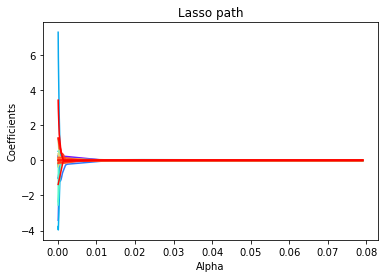

In [19]:
# graph of lasso path (coefficients given alpha)
import matplotlib.cm as cm
couleurs = cm.rainbow(np.linspace(0,1,len(indicators)))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alpha_for_path,coefs_lasso[0][i,:],c=couleurs[i])
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.show()

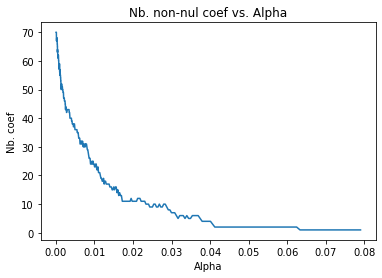

In [20]:
# number of non-nul coefficients for each alpha

nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. coef') 
plt.title('Nb. non-nul coef vs. Alpha') 
plt.show()

In [21]:
# get the alpha for which we get 8 selected features (and its index)
# If no such alpha exists, choose an alpha for which we get 7 selected features, etc...

alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
while np.isnan(higher_alpha_to_get_8_features) == True :
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
#index_higher_alpha_to_get_8_features

In [22]:
# get the 8 selected features coressponding 

coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
selected_features

['volume_fi',
 'volume_em',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'momentum_stoch']

# SVM

In [23]:
df_ML = Crypto[['volume_fi',
 'volume_em',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'momentum_stoch','Returns']]

y=Crypto[['Returns']]

X = Crypto[['volume_fi',
 'volume_em',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'momentum_stoch']]

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [25]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)
X_normalized_min_max = min_max_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized_min_max, y, test_size= 0.15, shuffle=False)
model = LinearRegression()

# Fit model
model.fit(X_train,y_train)

# Predict CO2 values
preds = model.predict(X_test)

In [26]:
def compute_Pi(X,y, n_splits=1000):
    """
    Computes the 95% CI intervals based on TimeSeries cross validation bootstrapping.
    Returns an array of shape (2, nbr samples).
    
    Parameters
    ==========
    X: (numpy.ndarray)
        Features array of the data of the whole data 
    y: (numpy.ndarray)
        Daily returns of the wole data
    
        
    Returns
    ==========
    Pi: (numpy.ndarray)
        Arrays of tuples with the 2.5th and the 97.5th percentile
        
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = np.empty(len(y))

    # Bootstrap over TimeSeries splits
    for train_index, test_index in tscv.split(X) :
        # Get sets
        train_x, train_y = X.iloc[train_index], y.iloc[train_index]
        # Train model
        model_tmp = LinearRegression().fit(train_x, train_y)
        # Compute predictions
        preds = model_tmp.predict(X)
        # Store predictions
        results = np.c_[results, preds]

    # Get 95% PI of predictions
    Pi = np.percentile(results, [2.5, 97.5], axis=1)
    return Pi

Pi = compute_Pi(X, y)

In [37]:
## Plot Pi evolution
import plotly.express as px
def plot_Pi_evolution(df_actual_pi, preds_array, Pi_array, title="") : 
    """
    Plot the actual profits measurements against the predictions with 95% CIs.
    
    Parameters
    ===========
    df_actual_pi: (pd.DataFrame) DataFrame containing the actual Profits measurements in a "Pi" column.
    preds_array: (np.array) Array containing the Profits predictions. Must be of same length as df_actual_pi.
    pi_array: (np.Array) Array containing the confidence intervals. Must be of shape (2, length of df_actual_pi).
    """
    # Isolate PI measurements
    df_plot_Pi_drifty = df_actual_pi.copy()
    #display(df_plot_PI_drifty.head(1))

    # Isolate predictions
    df_plot_Pi_preds = df_plot_Pi_drifty.copy()
    df_plot_Pi_preds["Returns"] = preds
    # Add PI
    df_plot_Pi_preds["PI"] = Pi_array[1,:] - Pi_array[0,:]
    #display(df_plot_PI_preds.head(1))
    df_plot_Pi_compare = pd.concat([df_plot_Pi_drifty.assign(origin="Real"), 
                                     df_plot_Pi_preds.assign(origin="Predicted")])\
                            .sort_index()\
                            .fillna(0)\
                            .reset_index()
    

    #display(df_plot_Pi_compare.head(4))

    # Plot 
    fig = px.line(df_plot_Pi_compare,
                  x="timestamp",
                  y="Pi",
                  color="origin",
                  error_y='Pi',
                  category_orders={"origin":["Predicted", "Real"]},
                  title=title,
                  )
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50))
    fig.show()
        
plot_Pi_evolution(Crypto['Returns'], preds, Pi, title="Profits estimated vs real")

AttributeError: 'Series' object has no attribute 'assign'

In [ ]:
# plot les graphs de Pi et des vrais returns

#Utiliser un guassian process pour voir si c'est + accurate

#Faire les MAE,MSE,... pour voir les différences


In [ ]:
# Get a nicer visualization with matplotlib for Confidence Intervals

def plot_Pi_evolution_nice(df, preds, Pi, title):
    


    fig, ax = plt.subplots(figsize=(18, 8))

    # Plotting of lines
    ax.plot(dates, preds, label='Pi Predictions')
    ax.plot(dates, Pi[0], 'b', alpha=0.3)
    ax.plot(dates, Pi[1], 'b', alpha=0.3)
    ax.plot(dates, y, 'r', label='Pi Measurements')
    ax.fill_between(dates, Pi[0], Pi[1], alpha=.3)

    ax.legend()
    ax.set_title('Pi Measurements vs Pi Predictions with 95% Confidence Interval', fontsize=18)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Pi')
    
    fig.suptitle(title, fontsize=22)
    fig.show()
    
plot_Pi_evolution_nice(df, preds, Pi, title='Returns predictions')